In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-3:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4342 - acc: 0.2335
Epoch 00001: val_loss improved from inf to 2.26445, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_3_conv_checkpoint/001-2.2645.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.4341 - acc: 0.2334 - val_loss: 2.2645 - val_acc: 0.2809
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8841 - acc: 0.3973
Epoch 00002: val_loss improved from 2.26445 to 1.77986, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_3_conv_checkpoint/002-1.7799.hdf5
36805/36805 [==============================] - 35s 948us/sample - loss: 1.8840 - acc: 0.3972 - val_loss: 1.7799 - val_acc: 0.4361
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7185 - acc: 0.7757
Epoch 00023: val_loss improved from 0.73209 to 0.71452, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_3_conv_checkpoint/023-0.7145.hdf5
36805/36805 [==============================] - 35s 952us/sample - loss: 0.7185 - acc: 0.7757 - val_loss: 0.7145 - val_acc: 0.7824
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7034 - acc: 0.7802
Epoch 00024: val_loss did not improve from 0.71452
36805/36805 [==============================] - 35s 946us/sample - loss: 0.7034 - acc: 0.7801 - val_loss: 0.7241 - val_acc: 0.7741
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6974 - acc: 0.7839
Epoch 00025: val_loss did not improve from 0.71452
36805/36805 [==============================] - 36s 965us/sample - loss: 0.6974 - acc: 0.7839 - val_loss: 0.7274 - val_acc: 0.7785
Epoch 26/500
36800/36805 [============================>.] -

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5483 - acc: 0.8286
Epoch 00050: val_loss did not improve from 0.61378
36805/36805 [==============================] - 35s 948us/sample - loss: 0.5483 - acc: 0.8286 - val_loss: 0.6338 - val_acc: 0.8078
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5407 - acc: 0.8327
Epoch 00051: val_loss did not improve from 0.61378
36805/36805 [==============================] - 35s 948us/sample - loss: 0.5407 - acc: 0.8326 - val_loss: 0.6378 - val_acc: 0.7985
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5406 - acc: 0.8299
Epoch 00052: val_loss did not improve from 0.61378
36805/36805 [==============================] - 36s 966us/sample - loss: 0.5407 - acc: 0.8299 - val_loss: 0.6231 - val_acc: 0.8057
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5332 - acc: 0.8324
Epoch 00053: val_loss did not improve from 0.61378
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.4667 - acc: 0.8528
Epoch 00077: val_loss did not improve from 0.57555
36805/36805 [==============================] - 35s 959us/sample - loss: 0.4668 - acc: 0.8528 - val_loss: 0.6229 - val_acc: 0.8057
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4640 - acc: 0.8537
Epoch 00078: val_loss did not improve from 0.57555
36805/36805 [==============================] - 35s 950us/sample - loss: 0.4641 - acc: 0.8537 - val_loss: 0.6156 - val_acc: 0.8097
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4620 - acc: 0.8532
Epoch 00079: val_loss improved from 0.57555 to 0.56696, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_3_conv_checkpoint/079-0.5670.hdf5
36805/36805 [==============================] - 35s 956us/sample - loss: 0.4620 - acc: 0.8532 - val_loss: 0.5670 - val_acc: 0.8255
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4138 - acc: 0.8699
Epoch 00106: val_loss did not improve from 0.55416
36805/36805 [==============================] - 35s 948us/sample - loss: 0.4139 - acc: 0.8699 - val_loss: 0.6168 - val_acc: 0.8109
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4130 - acc: 0.8690
Epoch 00107: val_loss did not improve from 0.55416
36805/36805 [==============================] - 35s 958us/sample - loss: 0.4131 - acc: 0.8690 - val_loss: 0.6262 - val_acc: 0.8029
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4158 - acc: 0.8676
Epoch 00108: val_loss did not improve from 0.55416
36805/36805 [==============================] - 35s 945us/sample - loss: 0.4157 - acc: 0.8676 - val_loss: 0.5667 - val_acc: 0.8248
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4098 - acc: 0.8701
Epoch 00109: val_loss did not improve from 0.55416
36805/36805 [=

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3786 - acc: 0.8802
Epoch 00136: val_loss did not improve from 0.55416
36805/36805 [==============================] - 35s 957us/sample - loss: 0.3786 - acc: 0.8802 - val_loss: 0.5922 - val_acc: 0.8227
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3817 - acc: 0.8786
Epoch 00137: val_loss did not improve from 0.55416
36805/36805 [==============================] - 35s 947us/sample - loss: 0.3817 - acc: 0.8786 - val_loss: 0.5914 - val_acc: 0.8202
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3786 - acc: 0.8784
Epoch 00138: val_loss did not improve from 0.55416
36805/36805 [==============================] - 35s 948us/sample - loss: 0.3787 - acc: 0.8784 - val_loss: 0.5682 - val_acc: 0.8297
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3809 - acc: 0.8782
Epoch 00139: val_loss did not improve from 0.55416
36805/36805 [=

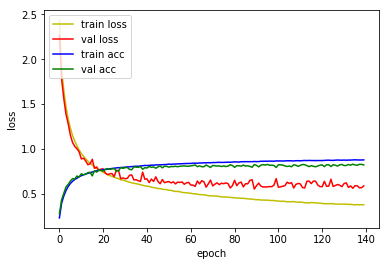

4815/4815 [==============================] - 2s 398us/sample - loss: 0.6380 - acc: 0.8004
Loss: 0.6380394508657921 Accuracy: 0.8004154

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4058 - acc: 0.2452
Epoch 00001: val_loss improved from inf to 2.40501, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_4_conv_checkpoint/001-2.4050.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 2.4057 - acc: 0.2453 - val_loss: 2.4050 - val_acc: 0.2385
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7953 - acc: 0.4134
Epoch 00002: val_loss improved from 2.40501 to 1.60068, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_4_conv_checkpoint/002-1.6007.hdf5
36805/36805 [==============================] - 36s 966us/sample - loss: 1.7953 - acc: 0.4134 - val_loss: 1.6007 - val_acc: 0.4906
Epoch 3/500
36800/36805 [============================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5040 - acc: 0.8465
Epoch 00023: val_loss improved from 0.55283 to 0.51480, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_4_conv_checkpoint/023-0.5148.hdf5
36805/36805 [==============================] - 36s 975us/sample - loss: 0.5040 - acc: 0.8465 - val_loss: 0.5148 - val_acc: 0.8353
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4908 - acc: 0.8507
Epoch 00024: val_loss improved from 0.51480 to 0.50886, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_4_conv_checkpoint/024-0.5089.hdf5
36805/36805 [==============================] - 36s 980us/sample - loss: 0.4908 - acc: 0.8507 - val_loss: 0.5089 - val_acc: 0.8444
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4803 - acc: 0.8524
Epoch 00025: val_loss did not improve from 0.50886
36805/36805 [==============================] - 35s 964us/sample - loss: 0.4804 - a

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3391 - acc: 0.8942
Epoch 00050: val_loss did not improve from 0.45012
36805/36805 [==============================] - 36s 965us/sample - loss: 0.3391 - acc: 0.8942 - val_loss: 0.4930 - val_acc: 0.8474
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3366 - acc: 0.8968
Epoch 00051: val_loss did not improve from 0.45012
36805/36805 [==============================] - 36s 969us/sample - loss: 0.3366 - acc: 0.8968 - val_loss: 0.4783 - val_acc: 0.8586
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3326 - acc: 0.8979
Epoch 00052: val_loss did not improve from 0.45012
36805/36805 [==============================] - 36s 972us/sample - loss: 0.3327 - acc: 0.8979 - val_loss: 0.4967 - val_acc: 0.8512
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3305 - acc: 0.8973
Epoch 00053: val_loss did not improve from 0.45012
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2663 - acc: 0.9168
Epoch 00078: val_loss did not improve from 0.42761
36805/36805 [==============================] - 35s 962us/sample - loss: 0.2663 - acc: 0.9168 - val_loss: 0.5089 - val_acc: 0.8456
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2617 - acc: 0.9179
Epoch 00079: val_loss did not improve from 0.42761
36805/36805 [==============================] - 36s 975us/sample - loss: 0.2617 - acc: 0.9179 - val_loss: 0.4494 - val_acc: 0.8647
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2579 - acc: 0.9205
Epoch 00080: val_loss did not improve from 0.42761
36805/36805 [==============================] - 35s 964us/sample - loss: 0.2579 - acc: 0.9205 - val_loss: 0.4756 - val_acc: 0.8642
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2573 - acc: 0.9199
Epoch 00081: val_loss did not improve from 0.42761
36805/36805 [==================

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2145 - acc: 0.9336
Epoch 00108: val_loss did not improve from 0.42761
36805/36805 [==============================] - 36s 973us/sample - loss: 0.2147 - acc: 0.9336 - val_loss: 0.5100 - val_acc: 0.8519
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2141 - acc: 0.9314
Epoch 00109: val_loss did not improve from 0.42761
36805/36805 [==============================] - 36s 982us/sample - loss: 0.2141 - acc: 0.9314 - val_loss: 0.4698 - val_acc: 0.8651
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2134 - acc: 0.9321
Epoch 00110: val_loss did not improve from 0.42761
36805/36805 [==============================] - 36s 967us/sample - loss: 0.2135 - acc: 0.9321 - val_loss: 0.4705 - val_acc: 0.8689
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2126 - acc: 0.9316
Epoch 00111: val_loss did not improve from 0.42761
36805/36805 [=

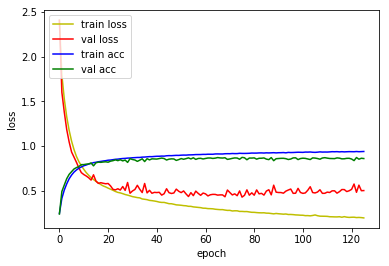

4815/4815 [==============================] - 2s 449us/sample - loss: 0.5293 - acc: 0.8430
Loss: 0.5293050099818011 Accuracy: 0.84299064

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0981 - acc: 0.3399
Epoch 00001: val_loss improved from inf to 1.83603, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_5_conv_checkpoint/001-1.8360.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.0981 - acc: 0.3400 - val_loss: 1.8360 - val_acc: 0.4484
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3554 - acc: 0.5842
Epoch 00002: val_loss improved from 1.83603 to 1.17594, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_5_conv_checkpoint/002-1.1759.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 1.3553 - acc: 0.5842 - val_loss: 1.1759 - val_acc: 0.6555
Epoch 3/500
36800/36805 [============================>

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2149 - acc: 0.9384
Epoch 00024: val_loss did not improve from 0.28725
36805/36805 [==============================] - 37s 995us/sample - loss: 0.2150 - acc: 0.9384 - val_loss: 0.2990 - val_acc: 0.9080
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2066 - acc: 0.9415
Epoch 00025: val_loss did not improve from 0.28725
36805/36805 [==============================] - 37s 995us/sample - loss: 0.2067 - acc: 0.9415 - val_loss: 0.3291 - val_acc: 0.9031
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2042 - acc: 0.9420
Epoch 00026: val_loss improved from 0.28725 to 0.27549, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_5_conv_checkpoint/026-0.2755.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.2042 - acc: 0.9420 - val_loss: 0.2755 - val_acc: 0.9150
Epoch 27/500
36800/36805 [============================>.] - E

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1003 - acc: 0.9722
Epoch 00053: val_loss improved from 0.27215 to 0.27025, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_5_conv_checkpoint/053-0.2703.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.1007 - acc: 0.9721 - val_loss: 0.2703 - val_acc: 0.9199
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1008 - acc: 0.9709
Epoch 00054: val_loss improved from 0.27025 to 0.26476, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_5_conv_checkpoint/054-0.2648.hdf5
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.1009 - acc: 0.9709 - val_loss: 0.2648 - val_acc: 0.9215
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0954 - acc: 0.9732
Epoch 00055: val_loss did not improve from 0.26476
36805/36805 [==============================] - 37s 999us/sample - loss: 0.0955 - acc: 

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0501 - acc: 0.9874
Epoch 00082: val_loss did not improve from 0.26476
36805/36805 [==============================] - 37s 1ms/sample - loss: 0.0501 - acc: 0.9874 - val_loss: 0.3138 - val_acc: 0.9187
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0495 - acc: 0.9876
Epoch 00083: val_loss did not improve from 0.26476
36805/36805 [==============================] - 36s 990us/sample - loss: 0.0498 - acc: 0.9876 - val_loss: 0.3539 - val_acc: 0.9106
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0526 - acc: 0.9865
Epoch 00084: val_loss did not improve from 0.26476
36805/36805 [==============================] - 37s 999us/sample - loss: 0.0526 - acc: 0.9866 - val_loss: 0.3421 - val_acc: 0.9136
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9890
Epoch 00085: val_loss did not improve from 0.26476
36805/36805 [=======

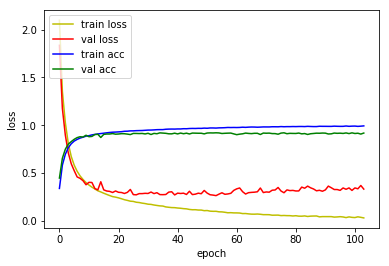

4815/4815 [==============================] - 2s 469us/sample - loss: 0.3276 - acc: 0.9022
Loss: 0.3276093834038217 Accuracy: 0.9021807

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8979 - acc: 0.4191
Epoch 00001: val_loss improved from inf to 1.50367, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_6_conv_checkpoint/001-1.5037.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.8978 - acc: 0.4192 - val_loss: 1.5037 - val_acc: 0.5674
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9856 - acc: 0.7182
Epoch 00002: val_loss improved from 1.50367 to 0.74815, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_6_conv_checkpoint/002-0.7482.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.9855 - acc: 0.7182 - val_loss: 0.7482 - val_acc: 0.7911
Epoch 3/500
36800/36805 [============================>.

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1085 - acc: 0.9698
Epoch 00024: val_loss did not improve from 0.18216
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1085 - acc: 0.9698 - val_loss: 0.1951 - val_acc: 0.9427
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1034 - acc: 0.9717
Epoch 00025: val_loss did not improve from 0.18216
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1034 - acc: 0.9717 - val_loss: 0.2196 - val_acc: 0.9320
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9742
Epoch 00026: val_loss did not improve from 0.18216
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0975 - acc: 0.9742 - val_loss: 0.1843 - val_acc: 0.9441
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9756
Epoch 00027: val_loss did not improve from 0.18216
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9934
Epoch 00054: val_loss did not improve from 0.18216
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0314 - acc: 0.9934 - val_loss: 0.2207 - val_acc: 0.9385
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9962
Epoch 00055: val_loss did not improve from 0.18216
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0231 - acc: 0.9963 - val_loss: 0.2064 - val_acc: 0.9455
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9961
Epoch 00056: val_loss did not improve from 0.18216
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0232 - acc: 0.9961 - val_loss: 0.2080 - val_acc: 0.9427
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0223 - acc: 0.9964
Epoch 00057: val_loss did not improve from 0.18216
36805/36805 [===========

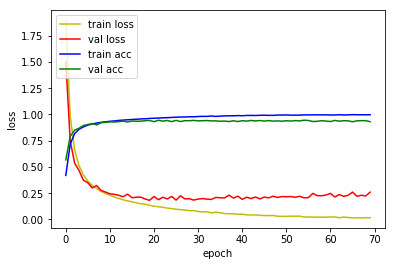

4815/4815 [==============================] - 3s 535us/sample - loss: 0.2230 - acc: 0.9313
Loss: 0.22299909570630588 Accuracy: 0.9312565

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6618 - acc: 0.4873
Epoch 00001: val_loss improved from inf to 1.26948, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_7_conv_checkpoint/001-1.2695.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 1.6619 - acc: 0.4873 - val_loss: 1.2695 - val_acc: 0.6355
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7949 - acc: 0.7689
Epoch 00002: val_loss improved from 1.26948 to 0.56756, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_7_conv_checkpoint/002-0.5676.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.7948 - acc: 0.7688 - val_loss: 0.5676 - val_acc: 0.8479
Epoch 3/500
36800/36805 [============================>

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9867
Epoch 00025: val_loss did not improve from 0.14830
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0573 - acc: 0.9867 - val_loss: 0.1614 - val_acc: 0.9506
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9869
Epoch 00026: val_loss did not improve from 0.14830
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0553 - acc: 0.9869 - val_loss: 0.1695 - val_acc: 0.9504
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0537 - acc: 0.9873
Epoch 00027: val_loss did not improve from 0.14830
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0537 - acc: 0.9873 - val_loss: 0.1853 - val_acc: 0.9439
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9905
Epoch 00028: val_loss did not improve from 0.14830
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9967
Epoch 00055: val_loss did not improve from 0.14830
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0157 - acc: 0.9967 - val_loss: 0.1799 - val_acc: 0.9550
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9985
Epoch 00056: val_loss did not improve from 0.14830
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0113 - acc: 0.9984 - val_loss: 0.1798 - val_acc: 0.9574
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9979
Epoch 00057: val_loss did not improve from 0.14830
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0122 - acc: 0.9979 - val_loss: 0.1734 - val_acc: 0.9550
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0080 - acc: 0.9992
Epoch 00058: val_loss did not improve from 0.14830
36805/36805 [===========

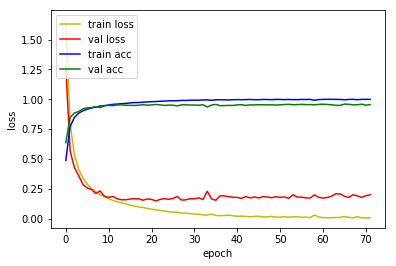

4815/4815 [==============================] - 3s 584us/sample - loss: 0.1966 - acc: 0.9379
Loss: 0.1966164680903822 Accuracy: 0.9379024

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5946 - acc: 0.5111
Epoch 00001: val_loss improved from inf to 1.27154, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_8_conv_checkpoint/001-1.2715.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 1.5945 - acc: 0.5111 - val_loss: 1.2715 - val_acc: 0.6401
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7226 - acc: 0.7846
Epoch 00002: val_loss improved from 1.27154 to 0.52836, saving model to model/checkpoint/1D_CNN_custom_multi_3_GMP_ch_32_BN_8_conv_checkpoint/002-0.5284.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.7226 - acc: 0.7846 - val_loss: 0.5284 - val_acc: 0.8437
Epoch 3/500
36800/36805 [============================>.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9893
Epoch 00024: val_loss did not improve from 0.16227
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0484 - acc: 0.9893 - val_loss: 0.1814 - val_acc: 0.9453
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9897
Epoch 00025: val_loss did not improve from 0.16227
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0453 - acc: 0.9897 - val_loss: 0.1729 - val_acc: 0.9492
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9903
Epoch 00026: val_loss did not improve from 0.16227
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0420 - acc: 0.9902 - val_loss: 0.1786 - val_acc: 0.9460
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9910
Epoch 00027: val_loss did not improve from 0.16227
36805/36805 [========================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9955
Epoch 00054: val_loss did not improve from 0.16227
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0183 - acc: 0.9955 - val_loss: 0.1833 - val_acc: 0.9506
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9993
Epoch 00055: val_loss did not improve from 0.16227
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0069 - acc: 0.9993 - val_loss: 0.1825 - val_acc: 0.9522
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9996
Epoch 00056: val_loss did not improve from 0.16227
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0053 - acc: 0.9996 - val_loss: 0.1876 - val_acc: 0.9513
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9982
Epoch 00057: val_loss did not improve from 0.16227
36805/36805 [===========

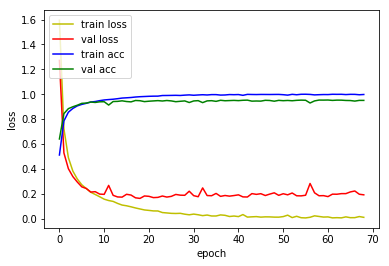

4815/4815 [==============================] - 3s 652us/sample - loss: 0.2249 - acc: 0.9308
Loss: 0.2249257017147504 Accuracy: 0.93084115



In [10]:
base = '1D_CNN_custom_multi_3_GMP_ch_32_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_GMP_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_GMP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 3s 646us/sample - loss: 0.5293 - acc: 0.8430
Loss: 0.5293050099818011 Accuracy: 0.84299064

1D_CNN_custom_multi_3_GMP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activati

4815/4815 [==============================] - 3s 687us/sample - loss: 0.2230 - acc: 0.9313
Loss: 0.22299909570630588 Accuracy: 0.9312565

1D_CNN_custom_multi_3_GMP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activati

4815/4815 [==============================] - 4s 796us/sample - loss: 0.2249 - acc: 0.9308
Loss: 0.2249257017147504 Accuracy: 0.93084115


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_GMP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 4s 766us/sample - loss: 0.6002 - acc: 0.8330
Loss: 0.6002456885013006 Accuracy: 0.8330218

1D_CNN_custom_multi_3_GMP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 4s 867us/sample - loss: 0.2955 - acc: 0.9259
Loss: 0.2954702365466491 Accuracy: 0.9258567

1D_CNN_custom_multi_3_GMP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 4s 917us/sample - loss: 0.2818 - acc: 0.9331
Loss: 0.28179021773246715 Accuracy: 0.9331257
